In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
import pydot
import h5py
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import random
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import time

%matplotlib inline

In [0]:
def load_dataset():
    path_to_train = "assignment3_train.h5"
    path_to_test = "assignment3_test.h5"

    train_dataset = h5py.File(path_to_train, "r")
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test, "r")
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # reshape y from (samples, ) to (1, samples)
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_x.shape[0]))

    # transpose y
    train_y = train_y.T
    test_y = test_y.T

    return train_x, train_y, test_x, test_y
def preprocess_data():
    train_x, train_y, test_x, test_y = load_dataset()

    # Normalize image vectors
    train_x = train_x/255.
    test_x = test_x/255.

    print ("number of training examples = " + str(train_x.shape[0]))
    print ("number of test examples = " + str(test_x.shape[0]))

    print ("X_train shape: " + str(train_x.shape))
    print ("Y_train shape: " + str(train_y.shape))
    print ("X_test shape: " + str(test_x.shape))
    print ("Y_test shape: " + str(test_y.shape))

    return train_x, train_y, test_x, test_y

def plot(training_results, validation_results, results_type, model_name):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)


def plot_accuracy(history, model_name):
    plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', model_name)    

def plot_loss(history, model_name):
    plot(history.history['loss'], history.history['val_loss'], 'Loss', model_name)

# CNN

In [0]:
def test_cnn_model(model_name, epochs=10, print_summary=True, plot_results=True):
    train_x, train_y, test_x, test_y = preprocess_data()

    x_tr, x_val, y_tr, y_val = train_test_split(train_x, train_y, random_state = 3)

    model = HappyModel(train_x.shape[1:])

    model.summary()
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
    history = model.fit(x_tr, y_tr, verbose=1, batch_size=16, epochs=epochs, validation_data=(x_val, y_val))
    loss, accuracy = model.evaluate(test_x, test_y, batch_size=16, verbose=0)
    print ("Loss = " + str(loss))
    print ("Test Accuracy = " + str(accuracy))
    plot_accuracy(history, model_name)
    plot_loss(history, model_name)

    # plot_model(model, to_file='HappyModel3_b.png')

In [0]:
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in tensorflow.keras
    """

    #TODO: Start Code Here, Make CNN by using tf.keras.layers, put last layer into tf.keras.models.Model
    X_input = Input(input_shape)
    X = BatchNormalization(axis = 3)(X_input)
    X = Conv2D(32, (7, 7), strides = (1, 1), activation='relu', padding = 'same')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Conv2D(64, (7, 7), strides = (1, 1), activation='relu')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    #TODO: End Code Here
    
    return model

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 32)        4736      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 26, 26, 64)        100416    
_________________________________________________________________
flatten_14 (Fl

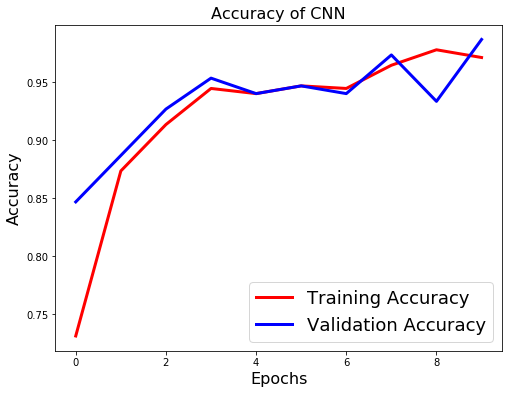

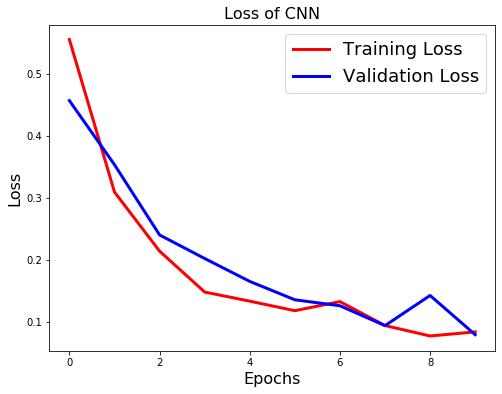

In [0]:
def test_CNN(epochs=10, print_summary=True, plot_results=True, model_name="CNN"):
    # TODO Call test_model from here with your defined CNN Model
    test_cnn_model("CNN", epochs, print_summary, plot_results)

test_CNN()

# VGG and ResNet

In [0]:
def compile_model(model, model_name, x_tr, y_tr,x_val, y_val, test_x, test_y, epochs=10):
  model.summary()
  adam = Adam(lr=0.001)
  model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
  history = model.fit(x_tr, y_tr, verbose=1, batch_size=16, epochs=epochs, validation_data=(x_val, y_val))
  start_time = int(round(time.time() * 1000))
  loss, accuracy = model.evaluate(test_x, test_y, batch_size=16, verbose=0)
  end_time = int(round(time.time() * 1000))
  print("--- %s milli-sec ---" % (end_time - start_time))
  print ("Loss = " + str(loss))
  print ("Test Accuracy = " + str(accuracy))
  plot_accuracy(history, model_name)
  plot_loss(history, model_name)
  # plot_model(model, to_file= model_name+'.png')

In [0]:
def plot_freeze(frozen_layers, accuracy):
  plt.plot(frozen_layers, accuracy)
  plt.show()

In [0]:
def add_l2_reg(model):
  max_reg = 30
  for x in model.layers[::-1]:
    if isinstance(x,Conv2D):
      flip = random.randint(0, 1)
      if flip == 1 and max_reg >= 0:
        x.kernel_regularizer= l2(0.02)
        max_reg = max_reg - 1
  
def add_l1_reg(model):
  max_reg = 30
  for x in model.layers[::-1]:
    if isinstance(x,Conv2D):
      flip = random.randint(0, 1)
      if flip == 1 and max_reg >= 0:
        x.kernel_regularizer= l1(0.02)
        max_reg = max_reg - 1

In [0]:
def test_model(model, model_name, epochs=10, print_summary=True, plot_results=True):
    train_x, train_y, test_x, test_y = preprocess_data()

    x_tr, x_val, y_tr, y_val = train_test_split(train_x, train_y, random_state = 3)
    compile_model(model, model_name, x_tr, y_tr,x_val, y_val, test_x, test_y)

In [0]:
# TODO redefine this faulty freeze layers method to perform as you studied in the lecture
def freeze(model, number_of_freezed_layers):
    layers = model.layers

    # Randomly choose layer to freeze
    for layer in layers:
        if number_of_freezed_layers > 0:
          layer.trainable = False
          number_of_freezed_layers -= 1

    return model


def test_Resnet(pretrained=True, freeze_layers=False, number_of_freezed_layers=0, epochs=10, print_summary=True, plot_results=True, model_name="ResNet"):

    if(pretrained):
        model_name = "Pretrained " + model_name
        # TODO define pretrained Resnet model
        base_model = applications.resnet.ResNet152(include_top=False, weights='imagenet', input_shape=(64,64,3), pooling='max')

    else:
        model_name = "Untrained " + model_name
        # TODO define Untrained Resnet model
        # Model with adding own output layers
        base_model = applications.resnet.ResNet152(include_top=False, weights=None, input_shape=(64,64,3), pooling='max')


    if freeze_layers:
        base_model = freeze(base_model, number_of_freezed_layers)

    # TODO define the top of your model (the output layers)
    resnet_model = Sequential()
    resnet_model.add(base_model)
    resnet_model.add(Flatten())
    resnet_model.add(BatchNormalization())
    resnet_model.add(Dense(512, activation='relu'))
    resnet_model.add(Dense(128, activation='relu'))
    resnet_model.add(Dense(2, activation='softmax'))

    test_model(resnet_model, model_name, epochs, print_summary, plot_results)


def test_VGG(pretrained=True, freeze_layers=False, number_of_freezed_layers=0, epochs=10, print_summary=True, plot_results=True, model_name="VGG"):


    if(pretrained):
        model_name = "Pretrained " + model_name
        # TODO define VGG pretrained model
        base_model = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3), pooling='max')
    else:
        model_name = "Untrained " + model_name
        # Note - Comment one of the following model on exe
        # Model with adding own output layers
        base_model = applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(64,64,3), pooling='max')

    if freeze_layers:
        base_model = freeze(base_model, number_of_freezed_layers)

    # TODO define the top of your model (the output layers)
    vgg_model = Sequential()
    vgg_model.add(base_model)
    vgg_model.add(Dense(512, activation='relu'))
    vgg_model.add(Dropout(0.4))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Dense(2, activation='softmax'))


    test_model(vgg_model, model_name, epochs, print_summary, plot_results)

In [0]:
test_Resnet(False, False, 0)

In [0]:
test_Resnet(True, True, 20)

In [0]:
test_VGG(False, False, 0)

In [0]:
test_VGG(True, True, 7)